In [1]:
import random
import torch
import matplotlib.pyplot as plt

c:\Python\Python3.10.5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()
len(words)

32033

Generate the trigrams

In [3]:
trigrams = {}
for w in words:
    chs = ['.'] + list(w) + ['.']

    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        trigram = (ch1, ch2, ch3)
        trigrams[trigram] = trigrams.get(trigram, 0) + 1
        #print(ch1, ch2, ch3)

sorted(trigrams.items(), key = lambda kv: -kv[1])
print(len(sorted(trigrams.items(), key = lambda kv: -kv[1])))

6037


string to integer and integer to string conversions

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # String to Int
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Int to String

Collect the distribution of trigrams within the names data

In [5]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):

        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

In [6]:
# Dim 1 ,  2,  3
#     27, 27, 27
#     27, 27,  1

In [7]:
# second letter probs are the sum of the third letter probs for each second letter
P_2 = (N+1).float().sum(2)
P_2 = P_2 / P_2.sum(1, keepdim=True)

In [8]:
# probability of the 3rd letter given the other 2
P_3 = (N+1).float()
P_3 = P_3/ P_3.sum(2, keepdim=True)

This approach generates the second letter as with the bigrams and subsequent letters with trigrams

In [9]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix1 = 0
    # generate first
    p_2 = P_2[ix1]
    ix2 = torch.multinomial(p_2, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix2])
    while True:
        p_3 = P_3[ix1][ix2]
        ix1 = ix2
        ix2 = torch.multinomial(p_3, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(out))

miq.
axx.
mereyannyaar.
knooraen.
el.


This approach generates all letters with trigrams

In [10]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix1, ix2 = 0, 0
    while True:
        p_3 = P_3[ix1][ix2]
        ix1 = ix2
        ix2 = torch.multinomial(p_3, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix2])
        if ix2 == 0:
            break
    #print(f"{ix1}, {ix2}")
    print(''.join(out))

quia.
yu.
quinslyntien.
nolliahi.
ha.


The next cells go through determining the loss of the probability distribution

In [11]:
xs , ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # print(w)
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # print(ch1 + ch2 + ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)


In [12]:
xs

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        ...,
        [26, 25],
        [25, 26],
        [26, 24]])

In [13]:
ys

tensor([13, 13,  1,  ..., 26, 24,  0])

In [14]:
nlls = torch.zeros(5)

for i in range(4):
    x1 , x2 = xs[i][0].item(), xs[i][1].item()
    y = ys[i].item()
    print('---------')
    print(f'trigram example {i+1}: {itos[x1]}{itos[x2]}{itos[y]} (indices {x1},{x2},{y})')
    print('input to the neural net:', x1, x2)
    print('output probabilities:', P_3[x1][x2])
    print('label (actual next character):', y)
    p = P_3[x1][x2][y]
    print('Probability of the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood', logp.item())
    nll = -logp
    print('negative log likelihood', nll.item())
    nlls[i] = nll

print('==========')
print('average negative log likelihood', nlls.mean().item())

---------
trigram example 1: .em (indices 0,5,13)
input to the neural net: 0 5
output probabilities: tensor([0.0006, 0.0154, 0.0103, 0.0032, 0.0520, 0.0064, 0.0071, 0.0045, 0.0064,
        0.0353, 0.0026, 0.0058, 0.3139, 0.1855, 0.0392, 0.0032, 0.0058, 0.0006,
        0.0584, 0.0603, 0.0135, 0.0141, 0.0995, 0.0032, 0.0032, 0.0160, 0.0340])
label (actual next character): 13
Probability of the correct character: 0.18549422919750214
log likelihood -1.6847314834594727
negative log likelihood 1.6847314834594727
---------
trigram example 2: emm (indices 5,13,13)
input to the neural net: 5 13
output probabilities: tensor([0.1621, 0.1771, 0.0352, 0.0013, 0.0013, 0.1018, 0.0013, 0.0013, 0.0013,
        0.2023, 0.0025, 0.0013, 0.0038, 0.1269, 0.0050, 0.0590, 0.0239, 0.0013,
        0.0276, 0.0050, 0.0013, 0.0151, 0.0013, 0.0013, 0.0013, 0.0377, 0.0013])
label (actual next character): 13
Probability of the correct character: 0.12688441574573517
log likelihood -2.064478635787964
negative log likel

In [15]:
n =  len(xs)
nlls = torch.zeros(n)
for i, x in enumerate(xs):
    x1, x2 = x[0].item(), x[1].item()
    y = ys[i].item()
    p = P_3[x1, x2, y]
    nlls[i]= -torch.log(p).item()
print(nlls.mean().item())


2.0930798053741455


It seems that the trigram generation from the probalities outperforms the bigram model.

Now for training a neural net to replicate the statistical distribution through backpropogation

In [16]:
xs , ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # print(w)
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # print(ch1 + ch2 + ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [17]:
import torch.nn.functional as F

For completeness I will encode the 2 letters in a 27X27* matrix even though its possible to do it in a 1X54 or 2X27 encoding.

/* At the end i realised this approach is not actually any different to the bigrams as I inadvertantly just made a model that works with the second letter of the trigram only.

In [18]:
g = torch.Generator().manual_seed(2145483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
W1 = torch.ones((1, 27))

In [19]:
xenc = F.one_hot(xs, num_classes=27).float()
xenc_27x27 = torch.zeros((196113,27,27))
print(xenc_27x27.shape)
for i, x in enumerate(xenc):
    i1 = xenc[i][0].nonzero()
    i2 = xenc[i][1].nonzero()
    xenc_27x27[i,i1, i2] +=1

torch.Size([196113, 27, 27])


Final loss: 2.43


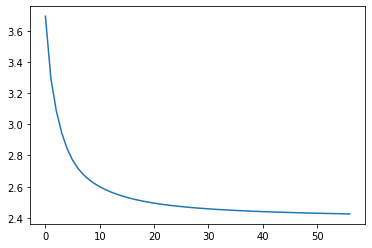

In [20]:
losses = [[],[]]
epochs = 100
count = 0
for k in range(epochs):
    # Forward
    out = xenc_27x27 @ W
    # print(out.shape)
    out = torch.squeeze((W1 @ out))
    # print(out.shape)
    # Softmax
    counts = out.exp()
    probs = counts/counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(196113), ys].log().mean() + 0.01*(W**2).mean()
    
    losses[0].append(k)
    losses[1].append(loss.item())

    W.grad=None
    loss.backward()

    W.data += -50*W.grad

    if k > 0 and abs(losses[1][k] - losses[1][k-1]) <= 0.001:
        count += 1
    else:
        count = 0
    if count == 10:
        break

plt.plot(losses[0], losses[1]);
print(f"Final loss: {loss.item():.2f}")


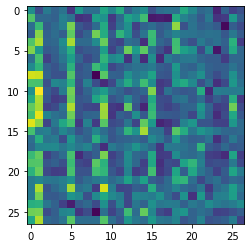

In [21]:
plt.imshow(W.detach().numpy())

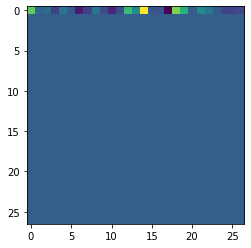

In [22]:
result = (xenc_27x27[4] @ W)
plt.imshow(result.detach().numpy())


This outperformed the bigram model at the same number of epochs and training rate. I have realised that this is actually not performing as expected and only the second letter of the trigram is actually doing anything.

In [23]:
g = torch.Generator().manual_seed(2147483647)
for i in range(30):
    word_out = []
    ix1 = 0
    ix2 = 0 
    while True:  
        xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
        i1 = xenc[0].nonzero()
        i2 = xenc[1].nonzero()
        xenc_27x27 = torch.zeros(27, 27)
        xenc_27x27[i1, i2] +=1
        out = xenc_27x27 @ W
        out = torch.squeeze((W1 @ out))
        counts = out.exp()
        p = counts/counts.sum()
        
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        word_out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(word_out))

oso.
axy.
ninaynnnyles.
kondmaisah.
.
ondwioy.
sie.
rabren.
jaddash.
jallligshan.
idyrer.
ia.
t.
cajayn.
jeimannariaenien.
da.
i.
bhijema.
.
usttanakerorvaeyaaxbrina.
n.
ksyonvrkiedengkh.
torrederahmokallovyllqcosjeca.
vai.
micg.
jahemenelgha.
ljanv.
ioyly.
ydahaha.
kayynnantsinn.


Trying again with 54X27

In [24]:
g = torch.Generator().manual_seed(2147483647)
xenc_1x54 = F.one_hot(xs, num_classes=27).float().flatten(start_dim=1)
W3 = torch.randn((54, 27), generator=g, requires_grad= True)


Final loss: 2.55


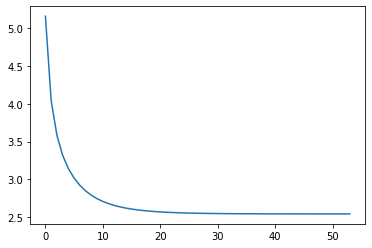

In [25]:
losses = [[],[]]
epochs = 100
for k in range(epochs):
    # Forward
    out = xenc_1x54 @ W3

    counts = out.exp()
    probs = counts/counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(len(ys)), ys].log().mean() + (W3**2).mean()
    losses[0].append(k)
    losses[1].append(loss.item())

    W3.grad=None
    loss.backward()
    W3.data += -50*W3.grad

    if k > 0 and abs(losses[1][k] - losses[1][k-1]) <= 0.0001:
        count += 1
    else:
        count = 0
    if count == 10:
        break

plt.plot(losses[0], losses[1]);
print(f"Final loss: {loss.item():.2f}")


In [26]:
g = torch.Generator().manual_seed(2147483647)
for i in range(30):
    word_out = []
    ix1 = 0
    ix2 = 0 
    while True:  
        xenc_1x54 = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float().flatten()
        out = xenc_1x54 @ W3
        counts = out.exp()
        p = counts/counts.sum()
        
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        word_out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(word_out))

otp.
ayt.
oriivitqzles.
konen.
grae.
apklyknzasle.
raanaiadah.
driabellnmetjeraefyujs.
ee.
va.
aliyn.
halialshoradlmer.
ah.
ea.
hilina.
aynrranedispqxcgzcewdwpon.
nahryshxxsphanilin.
worshann.
estdelltyxlrsaston.
aay.
fann.
halgenagllilel.
lialy.
erylu.
zeffigh.
kayynnamyrioras.
uarla.
ktulinvisanlaelleelit.
bonia.
uadieplfffxheuajprchtl.


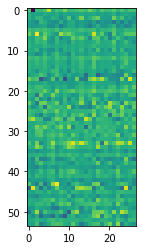

In [27]:
plt.imshow(W3.detach().numpy())
plt.imshow(W3.grad)

The 1X54 multiplied by 54X27 is the only method that completes quick enough it is however not a 'True' trigram model and istead functions by essentially summing up 2 bigram models. one taking the first and third letter and the other taking the second and third


In [28]:
# xenc = F.one_hot(xs, num_classes=27).float()
# i1 = xenc[0].nonzero()
# i2 = xenc[1].nonzero()
# xenc_27x27 = torch.zeros((196113,27,27))
# for i, x in enumerate(xenc):
#     i1 = xenc[i][0].nonzero()
#     i2 = xenc[i][1].nonzero()
#     xenc_27x27[i,i1, i2] +=1
# g = torch.Generator().manual_seed(2147483647)
# W4 = torch.randn((27, 27, 27), generator=g, requires_grad=True)
# out = torch.zeros((196113, 27, 27, 27))
# out = xenc_27x27[0] @ W4
#for i in range(5):
    #out[i] = xenc_27x27[i] @ W4
# doing 27x27x27 results in excess dimensions of the output which i am collapsing down using these W1 and W2
# tensors, I wasn't sure on how else to do it.
#W1 = torch.ones((1, 1, 27))
#W2 = torch.ones((1, 27))


# print(out.shape)
# out1 = torch.squeeze((W1 @ out))
# print(out1.shape)
# out2 = torch.squeeze((W2 @ out1))
# print(out2)
# # Turns out this is far too slow
# counts = out2.exp()
# probs = counts/counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(196113), ys].log().mean()
# print(loss.item())

Another approach with direct indexing allowing 


In [29]:
g = torch.Generator().manual_seed(2147483647)
W4 = torch.randn((27, 27, 27), generator=g, requires_grad=True)

Final loss: 2.14


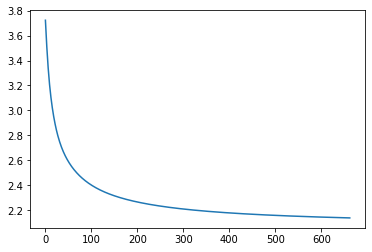

In [30]:
losses = [[],[]]
epochs = 1000
count = 0
for k in range(epochs):
    logits = W4[xs[:,0], xs[:, 1],]
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdim=True)

    loss = -probs[torch.arange(len(ys)), ys].log().mean()
    
    losses[0].append(k)
    losses[1].append(loss.item())

    W4.grad = None
    loss.backward()

    W4.data += -50 * W4.grad

    if k > 0 and abs(losses[1][k] - losses[1][k-1]) <= 0.0001:
        count += 1
    else:
        count = 0
    if count == 10:
        break

plt.plot(losses[0], losses[1]);
print(f"Final loss: {loss.item():.2f}")

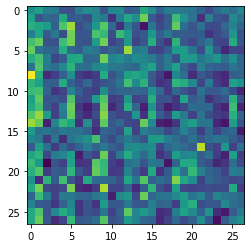

In [31]:
plt.imshow(W4[1].detach().numpy())

In [32]:
g = torch.Generator().manual_seed(2147483647)
for i in range(30):
    word_out = []
    ix1 = 0
    ix2 = 0 
    while True:  
        out = W4[ix1, ix2]
        counts = out.exp()
        p = counts/counts.sum()
        
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        word_out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(word_out))

uwa.
axx.
ton.
zhvlzqgy.
osellais.
oe.
uomsiny.
yia.
ya.
yaiddeleena.
okkpwlishaqrictwlt.
oe.
zaagenylainacelonikaireil.
ge.
oa.
orendecavity.
rhennfswady.
kylorie.
raivyontrina.
porilaymmon.
prcerreeannuwassarrin.
gavalann.
oakellekina.
olani.
ty.
orylo.
zafgjmoaleyvon.
yutmnvio.
zarle.
ottemiyan.


Moving on to tuning hyperparameters and evaluating the model

Split into train, dev and test sets and perform processing.

In [34]:
g = torch.Generator().manual_seed(2147483647)
sets = torch.utils.data.random_split(words, [0.8, 0.1, 0.1], generator=g)

train = sets[0]
dev = sets[1]
test = sets[2]

In [35]:
train_xs , train_ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # print(w)
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # print(ch1 + ch2 + ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        train_xs.append([ix1, ix2])
        train_ys.append(ix3)

train_xs = torch.tensor(train_xs)
train_ys = torch.tensor(train_ys)

In [36]:
dev_xs , dev_ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # print(w)
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # print(ch1 + ch2 + ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        dev_xs.append([ix1, ix2])
        dev_ys.append(ix3)

dev_xs = torch.tensor(dev_xs)
dev_ys = torch.tensor(dev_ys)

In [37]:
test_xs , test_ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    # print(w)
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # print(ch1 + ch2 + ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        test_xs.append([ix1, ix2])
        test_ys.append(ix3)

test_xs = torch.tensor(test_xs)
test_ys = torch.tensor(test_ys)

In [54]:
smoothing_constants = torch.arange(0.00, 0.11, 0.01)
epochs = 100
losses = torch.zeros((3, len(smoothing_constants)))
for i, s in enumerate(smoothing_constants):
    g = torch.Generator().manual_seed(2147483647)
    W_test = torch.randn((27, 27, 27), generator=g, requires_grad=True)
    # Train
    for k in range(epochs):
        logits = W_test[train_xs[:,0], train_xs[:, 1],]
        # counts = logits.exp()
        # probs = counts/counts.sum(1, keepdim=True)

        # train_loss = -probs[torch.arange(len(train_ys)), train_ys].log().mean() + s * (W_test**2).mean()
        train_loss = F.cross_entropy(logits, train_ys, label_smoothing=s)
        W_test.grad = None
        train_loss.backward()
        W_test.data += -50 * W_test.grad

    losses[0, i] = train_loss.item()

    logits = W_test[dev_xs[:,0], dev_xs[:, 1],]
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)

    # dev_loss = -probs[torch.arange(len(dev_ys)), dev_ys].log().mean() + s * (W_test**2).mean()
    dev_loss = F.cross_entropy(logits, dev_ys, label_smoothing=s)
    losses[1, i] = dev_loss.item()

    # logits = W_test[test_xs[:,0], test_xs[:, 1],]
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)

    # test_loss = -probs[torch.arange(len(test_ys)), test_ys].log().mean() + s * (W_test**2).mean()
    test_loss = F.cross_entropy(logits, test_ys, label_smoothing=s)
    losses[2, i] = test_loss.item()

    print(f"{s=}: {train_loss=:.4f}: {dev_loss=:.4f}: {test_loss=:.4f}:")


s=tensor(0.): train_loss=2.4025: dev_loss=2.4001: test_loss=2.4001:
s=tensor(0.0100): train_loss=2.4216: dev_loss=2.4193: test_loss=2.4193:
s=tensor(0.0200): train_loss=2.4405: dev_loss=2.4382: test_loss=2.4382:
s=tensor(0.0300): train_loss=2.4592: dev_loss=2.4569: test_loss=2.4569:
s=tensor(0.0400): train_loss=2.4776: dev_loss=2.4754: test_loss=2.4754:
s=tensor(0.0500): train_loss=2.4959: dev_loss=2.4937: test_loss=2.4937:
s=tensor(0.0600): train_loss=2.5139: dev_loss=2.5117: test_loss=2.5117:
s=tensor(0.0700): train_loss=2.5317: dev_loss=2.5296: test_loss=2.5296:
s=tensor(0.0800): train_loss=2.5493: dev_loss=2.5472: test_loss=2.5472:
s=tensor(0.0900): train_loss=2.5666: dev_loss=2.5646: test_loss=2.5646:
s=tensor(0.1000): train_loss=2.5838: dev_loss=2.5818: test_loss=2.5818:


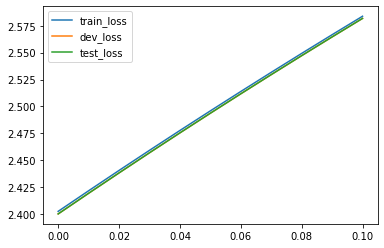

In [55]:
smoothing_constants = torch.arange(0.00, 0.11, 0.01)
plt.plot(smoothing_constants, losses[0].detach())
plt.plot(smoothing_constants, losses[1].detach())
plt.plot(smoothing_constants, losses[2].detach())
plt.legend(['train_loss', 'dev_loss', 'test_loss']);

Smoothing_constants are not appearing to help in this case as with bigrams

Learning rate

In [78]:
lrs = torch.arange(300, 450, 10)
epochs = 100
losses = torch.zeros((3, len(lrs)))
for i, lr in enumerate(lrs):
    g = torch.Generator().manual_seed(2147483647)
    W_test = torch.randn((27, 27, 27), generator=g, requires_grad=True)
    # Train
    for k in range(epochs):
        logits = W_test[train_xs[:,0], train_xs[:, 1],]
        # counts = logits.exp()
        # probs = counts/counts.sum(1, keepdim=True)

        # train_loss = -probs[torch.arange(len(train_ys)), train_ys].log().mean()
        train_loss = F.cross_entropy(logits, train_ys)
        W_test.grad = None
        train_loss.backward()
        W_test.data += -lr * W_test.grad

    losses[0, i] = train_loss.item()

    logits = W_test[dev_xs[:,0], dev_xs[:, 1],]
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)

    # dev_loss = -probs[torch.arange(len(dev_ys)), dev_ys].log().mean()
    dev_loss = F.cross_entropy(logits, dev_ys)
    losses[1, i] = dev_loss.item()
    
    logits = W_test[test_xs[:,0], test_xs[:, 1],]
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)

    # test_loss = -probs[torch.arange(len(test_ys)), test_ys].log().mean()
    test_loss = F.cross_entropy(logits, test_ys)
    losses[2, i] = test_loss.item()

    print(f"{lr=}: {train_loss=:.4f}: {dev_loss=:.4f}: {test_loss=:.4f}:")

lr=tensor(300): train_loss=2.1436: dev_loss=2.1429: test_loss=2.1429:
lr=tensor(310): train_loss=2.1414: dev_loss=2.1407: test_loss=2.1407:
lr=tensor(320): train_loss=2.1399: dev_loss=2.1394: test_loss=2.1394:
lr=tensor(330): train_loss=2.1383: dev_loss=2.1382: test_loss=2.1382:
lr=tensor(340): train_loss=2.1368: dev_loss=2.1372: test_loss=2.1372:
lr=tensor(350): train_loss=2.1354: dev_loss=2.1362: test_loss=2.1362:
lr=tensor(360): train_loss=2.1340: dev_loss=2.1353: test_loss=2.1353:
lr=tensor(370): train_loss=2.1327: dev_loss=2.1346: test_loss=2.1346:
lr=tensor(380): train_loss=2.1314: dev_loss=2.1339: test_loss=2.1339:
lr=tensor(390): train_loss=2.1302: dev_loss=2.1332: test_loss=2.1332:
lr=tensor(400): train_loss=2.1290: dev_loss=2.1327: test_loss=2.1327:
lr=tensor(410): train_loss=2.1279: dev_loss=2.1322: test_loss=2.1322:
lr=tensor(420): train_loss=2.1268: dev_loss=2.1317: test_loss=2.1317:
lr=tensor(430): train_loss=2.1269: dev_loss=2.1342: test_loss=2.1342:
lr=tensor(440): trai

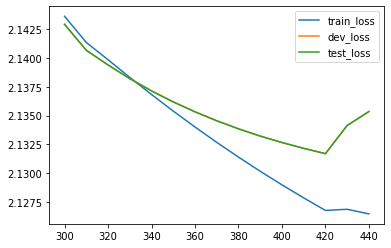

In [79]:
plt.plot(lrs, losses[0].detach())
plt.plot(lrs, losses[1].detach())
plt.plot(lrs, losses[2].detach())
plt.legend(['train_loss', 'dev_loss', 'test_loss']);

After Some iterations the training rate 330 seemed to be the best

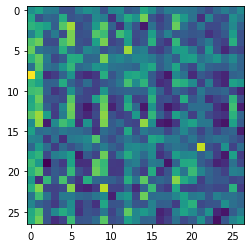

In [80]:
plt.imshow(W_test[1].detach().numpy())

In [83]:
g = torch.Generator().manual_seed(2147483647)
W_final = torch.randn((27, 27, 27), generator=g, requires_grad=True)
epochs = 1000
lr = 330
losses = torch.zeros((3, epochs))
# Train
for k in range(epochs):
    logits = W_final[train_xs[:,0], train_xs[:, 1],]

    train_loss = F.cross_entropy(logits, train_ys)
    W_final.grad = None
    train_loss.backward()
    W_final.data += -lr * W_final.grad
    losses[0, k] = train_loss.item()

    logits = W_final[dev_xs[:,0], dev_xs[:, 1],]
    dev_loss = F.cross_entropy(logits, dev_ys)
    losses[1, k] = dev_loss.item()

    logits = W_final[test_xs[:,0], test_xs[:, 1],]
    test_loss = F.cross_entropy(logits, test_ys)
    losses[2, k] = test_loss.item()

    if k > 0 and losses[2][k] - losses[2][k-1] >= 0.1 :
        count += 1
    else:
        count = 0
    if count == 5:
        break


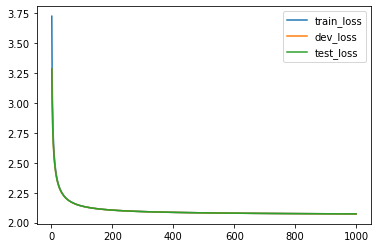

In [84]:
index = torch.arange(1, 1001, 1)
plt.plot(index, losses[0].detach())
plt.plot(index, losses[1].detach())
plt.plot(index, losses[2].detach())
plt.legend(['train_loss', 'dev_loss', 'test_loss']);

In [86]:
g = torch.Generator().manual_seed(2147483647)
for i in range(30):
    word_out = []
    ix1 = 0
    ix2 = 0 
    while True:  
        out = W_final[ix1, ix2]
        
        counts = out.exp()
        p = counts/counts.sum()
        
        ix1 = ix2
        ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() 
        word_out.append(itos[ix2])
        if ix2 == 0:
            break
    print(''.join(word_out))

ush.
axx.
ton.
zhoryian.
osellais.
od.
undylizarle.
ya.
yaiddeldashamannelishaqschuthi.
odaw.
elilyn.
ombelljaxtlenian.
ge.
oa.
orendecatrutaniahermojazacquindeel.
pryn.
zylie.
porilaymira.
pracloganniyonis.
yusaad.
zaiaheli.
olena.
ron.
olann.
ty.
orylo.
zaehali.
olytorentonanan.
zarle.
ottemiyanah.


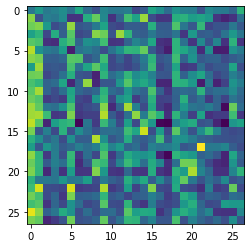

In [99]:
plt.imshow(W_final[5].detach().numpy())

The higher probabilities of vowels following consonants and not other vowels and vice versa can be seen in the pattern of weights.